# PCA on 8 upper atm variables, followed by kmeans

Datails.... 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np
import torch

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

### Load model output data

In [3]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [4]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [5]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# PCA on 1st variable

In [6]:
load_uatm_erai()

Days loaded 13515


In [17]:
#A = torch.ones(2,2,2,3)
#A = torch.tensor(np.array(mdv1[0:1]))
A = torch.tensor(np.array(mdv1)).flatten(1)
A.shape

torch.Size([13515, 324])

In [18]:
# PCA
U, S, V = torch.pca_lowrank(A)

In [19]:
print(U.shape)
print(S.shape)
print(V.shape)

torch.Size([13515, 6])
torch.Size([6])
torch.Size([324, 6])


In [20]:
torch.transpose(V, 0, 1).shape

torch.Size([6, 324])

In [21]:
# approximate original, AA = USV
print(U.shape)
print(S.shape)
print(V.shape)
SV = torch.matmul(torch.diag(S) , torch.transpose(V, 0, 1) )
SV.shape
AA = torch.matmul(U , SV)
print(AA.shape)

torch.Size([13515, 6])
torch.Size([6])
torch.Size([324, 6])
torch.Size([13515, 324])


torch.Size([324])


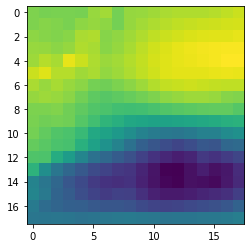

In [23]:
# 1st primary component 
U1 = U[0]*0 
U1[0] = 1
U1

# graph 1st component
AA = torch.matmul(U1 , SV)
print(AA.shape)
plt.imshow(AA.view(18,18))

tensor([1., -0., -0., -0., 0., -0.])
torch.Size([324])


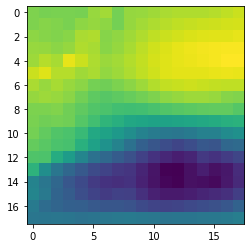

tensor([0., 1., -0., -0., 0., -0.])
torch.Size([324])


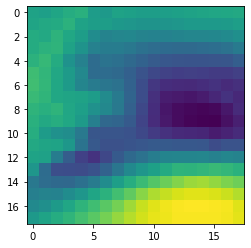

tensor([0., -0., 1., -0., 0., -0.])
torch.Size([324])


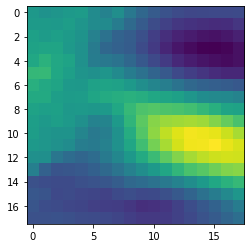

tensor([0., -0., -0., 1., 0., -0.])
torch.Size([324])


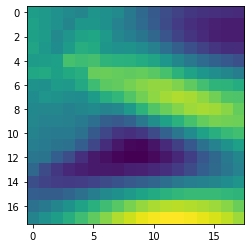

tensor([0., -0., -0., -0., 1., -0.])
torch.Size([324])


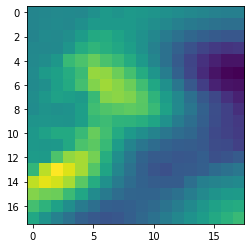

tensor([0., -0., -0., -0., 0., 1.])
torch.Size([324])


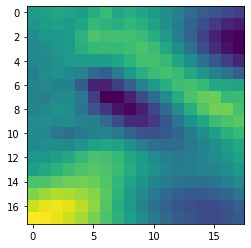

In [24]:
# show all 6 components
for ii in range(6):
    UU = U[0]*0 
    UU[ii] = 1
    print(UU)

    # graph 1st component
    AA = torch.matmul(UU , SV)
    print(AA.shape)
    plt.imshow(AA.view(18,18))
    plt.show()

### Let's reproduce each day of  1st variable (U850) from just 6 numbers!

In [25]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature


Reconstruct vs actual (U850)
0 tensor([ 0.0033, -0.0011, -0.0126, -0.0106,  0.0054, -0.0199])


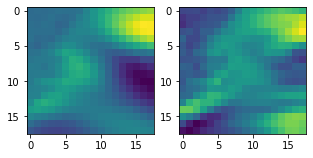

1 tensor([ 0.0102, -0.0033, -0.0015, -0.0008, -0.0010,  0.0010])


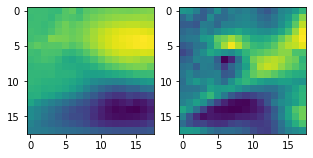

2 tensor([ 0.0047,  0.0040, -0.0092,  0.0028,  0.0011,  0.0052])


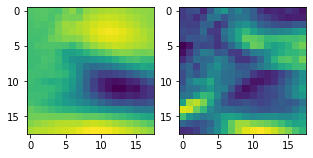

3 tensor([ 0.0060,  0.0011, -0.0111, -0.0099,  0.0144, -0.0055])


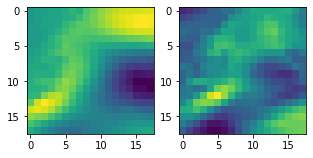

4 tensor([ 0.0122, -0.0024, -0.0112, -0.0076,  0.0004, -0.0142])


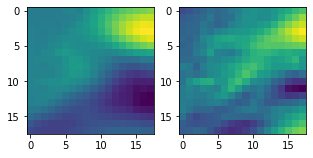

5 tensor([ 0.0115, -0.0096,  0.0009, -0.0036,  0.0168, -0.0146])


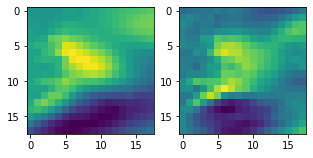

6 tensor([ 0.0072, -0.0272,  0.0094, -0.0012, -0.0050,  0.0108])


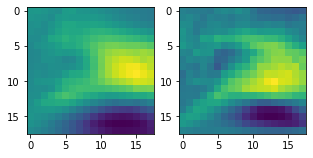

7 tensor([-0.0062, -0.0106, -0.0007,  0.0043, -0.0129, -0.0040])


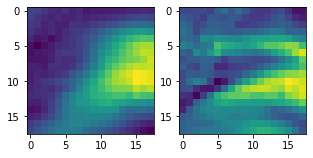

8 tensor([-0.0110, -0.0018, -0.0047,  0.0075, -0.0135, -0.0127])


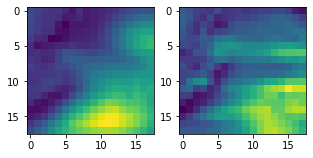

9 tensor([-0.0002, -0.0038,  0.0106,  0.0087,  0.0027, -0.0180])


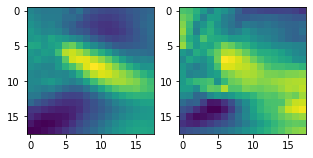

10 tensor([-0.0010, -0.0282,  0.0168, -0.0136,  0.0113,  0.0032])


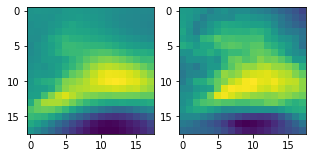

11 tensor([-0.0070, -0.0089,  0.0131, -0.0078, -0.0136, -0.0115])


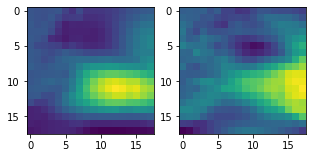

12 tensor([-0.0138, -0.0080,  0.0004, -0.0075,  0.0231, -0.0060])


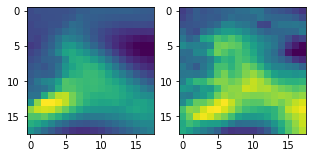

13 tensor([-0.0059,  0.0007, -0.0074,  0.0049, -0.0072, -0.0075])


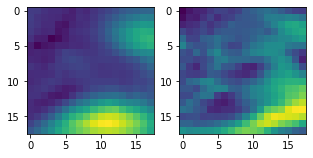

14 tensor([ 0.0048,  0.0019, -0.0023, -0.0037,  0.0192, -0.0149])


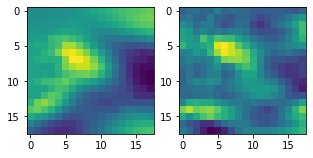

15 tensor([ 0.0024, -0.0007, -0.0039,  0.0079,  0.0115,  0.0022])


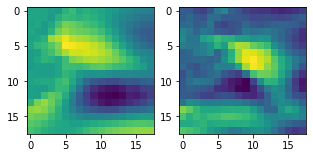

16 tensor([ 0.0054, -0.0066,  0.0002,  0.0094,  0.0021,  0.0054])


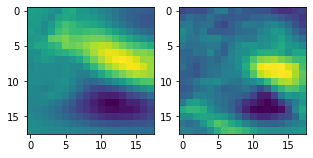

17 tensor([ 0.0045, -0.0054,  0.0017, -0.0013, -0.0073, -0.0023])


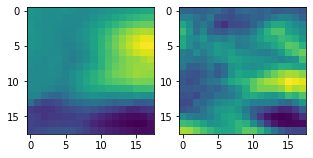

18 tensor([-7.6049e-03,  2.7206e-03, -7.8449e-05,  4.5657e-03, -6.9177e-03,
         7.6268e-05])


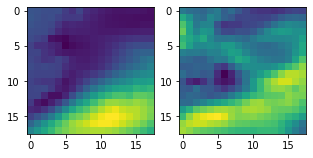

19 tensor([-0.0114,  0.0022, -0.0017,  0.0007, -0.0087,  0.0138])


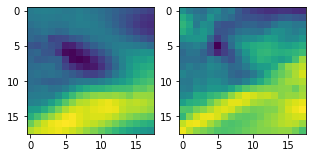

In [26]:
AA = torch.matmul(U , SV)
print("Reconstruct vs actual (U850)")
for ii in range(20):
    print(ii, U[ii])
    #fig, axarr = plt.subplots(1, 2, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    fig, axarr = plt.subplots(1, 2, figsize = (5,5))
    
    #axarr[ii].coastlines()
    #axarr[ii].add_feature(cfeature.STATES)
    #img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
    plot = axarr[0].imshow(AA[ii].view(18,18))  
    plot = axarr[1].imshow(A[ii].view(18,18))  
    plt.show()

### Kmeans

In [34]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
import scipy.cluster

In [35]:
scipy.cluster.vq.kmeans(U, 6)

(array([[ 0.00154477, -0.00676354,  0.00824558, -0.00683167, -0.00044172,
          0.00664456],
        [-0.0015831 , -0.00132768,  0.00540552,  0.01110722,  0.00369041,
         -0.00328616],
        [-0.00419319, -0.00845398, -0.00700778, -0.00116425, -0.00297338,
         -0.00430367],
        [-0.00308206,  0.00618785,  0.00037253, -0.00588822,  0.00579036,
         -0.00372405],
        [ 0.00458243,  0.00169556, -0.00720606,  0.00381205,  0.00459172,
          0.00866741],
        [ 0.00318346,  0.00498166,  0.00143643,  0.00019109, -0.00825384,
         -0.0008288 ]], dtype=float32),
 0.016116899)